# A simple, yet complete, tutorial on how use the CCS_fit module to fit two-body interactions

In [27]:
#REMOVE SOME HARD CODING. FOR EXAMPLE: "Ne-Ne" and "Ne" which is used further down.


import numpy as np
from ase.io import read,write
from ase.build import bulk
import ase.db as db
from ase.visualize import view
from ase.calculators.lj import LennardJones
import matplotlib.pyplot as plt

atom = 'Fe'
sigma = 2.26738
epsilon = 0.70641
N = 2

LJ=bulk(atom,'bcc', a=2.866)
LJ=LJ*[N, N, N]
calc = LennardJones(sigma=sigma, epsilon=epsilon)
LJ.calc = calc 

Fit_on_forces=True  #Enable/disable option for fitting CCS potential to atomic forces. 



### Generate training data
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale. 


In [28]:
# CHECK THE RATTLE FUNCTION TO MAKE SURE THAT WE DO NOT GET THE SAME RATTLES EVERYTIME

orig_cell = LJ.get_cell()
orig_struc = LJ.copy()

displacement_magnitude=0.02  # 0.02 and disp_steps 5 leads to decieving results!
disp_steps=5
rounds=5 # Decreased the rounds by a factor of 4 to increase the speed during testing phase.

trainset_list="file_list" # List of strucutres to include in the data-base (see below)
f = open(trainset_list, "w")
counter=1
for round in range(rounds):
    for scale in np.linspace(0.96, 1.04, 9):
        new_cell = orig_cell*scale
        new_struc = orig_struc.copy()
        new_struc.set_cell(new_cell)
        new_struc.calc = calc
        nrg = new_struc.get_potential_energy()
        for i in range(disp_steps):
            rattle_struc = new_struc.copy()
            rattle_struc.rattle(displacement_magnitude*i)
            rattle_struc.calc = calc
            nrg = rattle_struc.get_potential_energy()
            if nrg < -40:
                xyz_file=f"CALCULATED_DATA/S{counter}.xyz"
                write(xyz_file, rattle_struc)
                print(xyz_file, file=f)
                counter += 1

f.close()
       

### BUILD REFERENCE DATA-BASE

After generating the data, we collect it in an ASE database file. The ``file_list`` is a file containing a list of files to be collected into the data base.

Example of a ``file_list`` file:

    CALCULATED_DATA/S2.xyz
    CALCULATED_DATA/S3.xyz
    CALCULATED_DATA/S4.xyz
    CALCULATED_DATA/S5.xyz
    CALCULATED_DATA/S6.xyz
    CALCULATED_DATA/S7.xyz
    CALCULATED_DATA/S8.xyz
    CALCULATED_DATA/S9.xyz



In [29]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode='CSS', DFT_DB='LJ.db', file_list='file_list', overwrite=True)

    Building data-bases: 100%|██████████| 100/100 [00:50<00:00,  2.00it/s]


### Generate the CCS_fit input file; structures.json
The next commands fetch the training-set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called ``DFT_DB`` since the most common source of reference data is DFT.

In [30]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="LJ.db",include_forces=Fit_on_forces)

    Fetching data: 100%|██████████| 100/100 [00:00<00:00, 105.70it/s]


### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key.


In [32]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                f'{atom}-{atom}': {
                        "Rcut": 5.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono"

                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [33]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Fe']
    Applying monotonous constraints for pair:  Fe-Fe
    Merging intervall for pair Fe-Fe. Number of knots reduced from 281 to 175. 
    Condition number is: 11375609500568.24 ( 175 95147.34661449365 8.364151886655299e-09)


    Finding optimum switch: 100%|██████████| 175/175 [00:03<00:00, 54.50it/s]


    The best switch is (70,) with mse: 5.6786e-05 
    Final root mean square error in fit:  0.0006243588232177241  (eV/atoms) [NOTE: Only elements specified in Onebody are considered!]


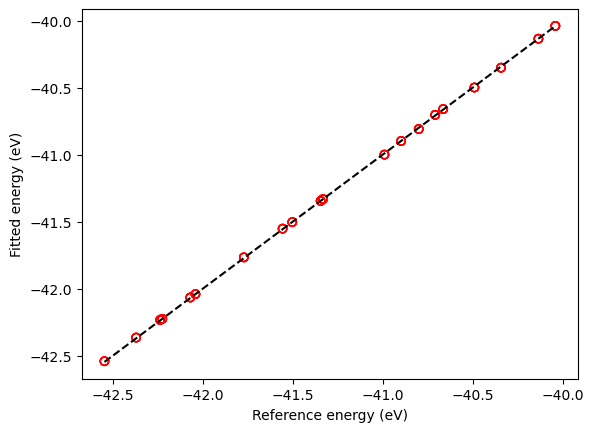

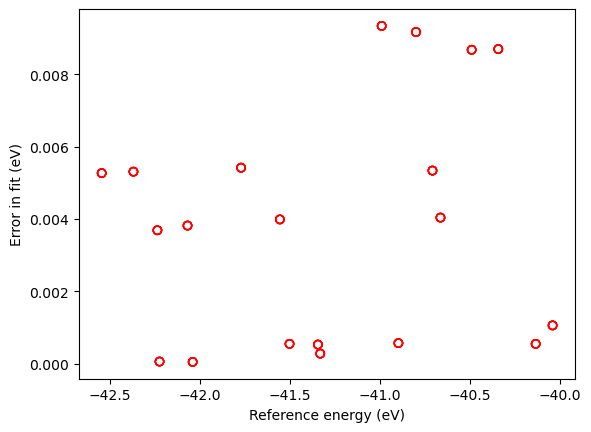

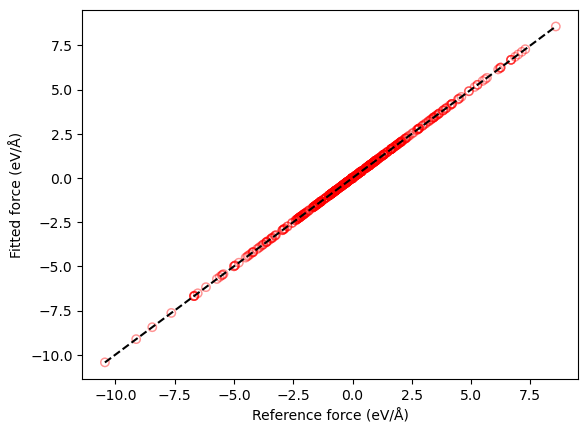

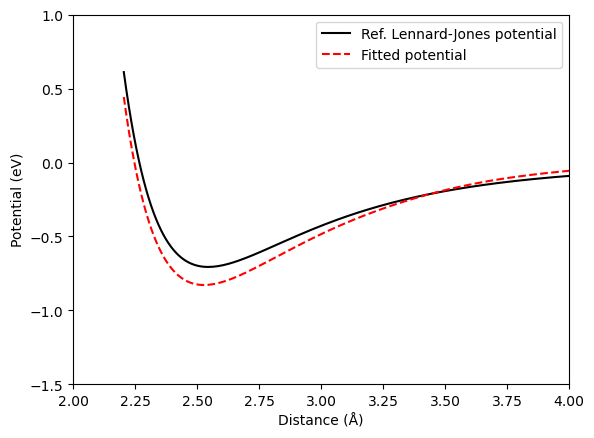

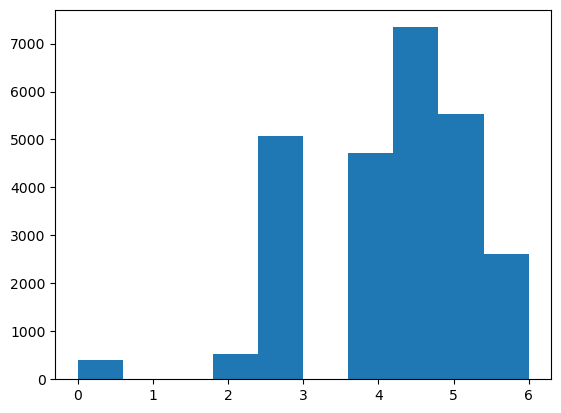

In [34]:
with open("CCS_params.json", "r") as f:
    CCS_params = json.load(f)

with open("structures.json", "r") as f:
    training_set = json.load(f)

r=np.array(CCS_params["Two_body"][f'{atom}-{atom}']["r"])
e=CCS_params["Two_body"][f'{atom}-{atom}']["spl_a"]

try:
    err=np.loadtxt("CCS_error.out")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Fitted energy (eV)')
    plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
    plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass

try:
    err_F=np.loadtxt("CCS_error_forces.out")
    plt.xlabel('Reference force (eV/Å)')
    plt.ylabel('Fitted force (eV/Å)')
    plt.plot( [min(err_F[:,0]),max(err_F[:,0])],[min(err_F[:,0]),max(err_F[:,0])],'--',color='black')
    plt.scatter(err_F[:,0],err_F[:,1],facecolors='none', edgecolors='red',alpha=0.1 )
    plt.show()
except:
    pass

e_LJ = 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)    #Maybe implement sigma and epsilon values here or use calculator?
plt.xlim(2,4)
plt.ylim(-1.5,1)
plt.xlabel('Distance (Å)')
plt.ylabel('Potential (eV)')
plt.plot(r,e_LJ,color='black',label="Ref. Lennard-Jones potential")
plt.plot(r,e,'--',color='red',label="Fitted potential")
plt.legend()
plt.show()

d=[]
for t in training_set["energies"]:
    d.extend(training_set["energies"][t][f'{atom}-{atom}'])

plt.hist(d) #Vad visar detta?
plt.show()


### Validate your potential
Make sure your potential (at least) reproduce the data points in your training-set. Performin further tests on strucutres not included in the training-set is recomended but not included in the tutorial.

In [35]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS",CCS_params="CCS_params.json",DFT_DB="LJ.db")

  0%|          | 0/100 [00:00<?, ?it/s]/home/armin/anaconda3/envs/CCSmin/lib/python3.9/site-packages/ase/utils/__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


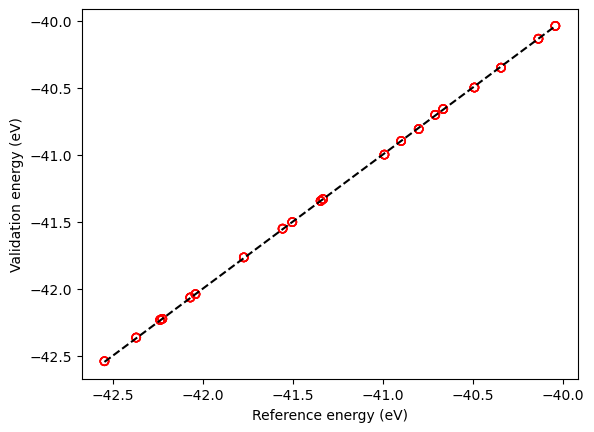

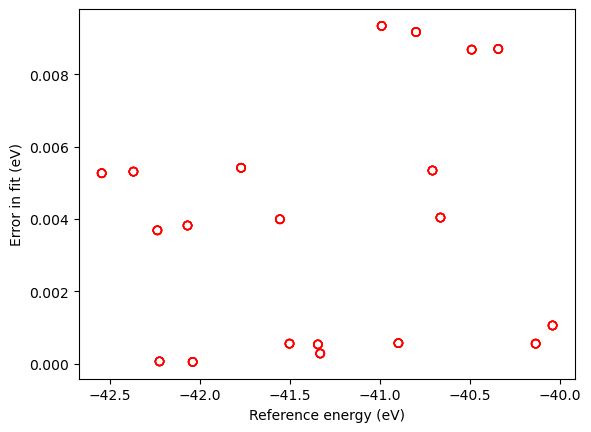

In [36]:
try:
    err=np.loadtxt("CCS_validate.dat")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Validation energy (eV)')
    plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
    plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass

### Geometry optimization

In [37]:
from ase.optimize import BFGS 
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS
from tqdm import tqdm

struct = db.connect('LJ.db')
calc = CCS(CCS_params=CCS_params)

for row in tqdm(struct.select(), total=len(struct)):
    structure = row.toatoms()
    structure.calc = calc
    structure.get_forces()
    struct.write(structure, CCS=True)

opt = BFGS(structure, trajectory='opt.traj')
opt.run(fmax=0.05)

  0%|          | 0/100 [00:00<?, ?it/s]/home/armin/anaconda3/envs/CCSmin/lib/python3.9/site-packages/ase/db/core.py:105: UserWarning: It is best not to use keys (CCS) that are also a chemical formula.  If you do a "db.select('CCS')",you will not find rows with your key.  Instead, you wil get rows containing the atoms in the formula!
  warnings.warn(
100%|██████████| 100/100 [00:41<00:00,  2.43it/s]

      Step     Time          Energy         fmax
BFGS:    0 13:32:31      -40.351925        2.7140
BFGS:    1 13:32:31      -40.718234        0.9796
BFGS:    2 13:32:31      -40.776887        0.2808
BFGS:    3 13:32:31      -40.780892        0.2248
BFGS:    4 13:32:31      -40.783091        0.0770


BFGS:    5 13:32:31      -40.783394        0.0575
BFGS:    6 13:32:31      -40.783758        0.0803
BFGS:    7 13:32:31      -40.785142        0.2059
BFGS:    8 13:32:31      -40.794678        0.9949
BFGS:    9 13:32:31      -40.745459        2.2250
BFGS:   10 13:32:31      -40.808827        1.0311
BFGS:   11 13:32:31      -40.822821        0.9948
BFGS:   12 13:32:31      -40.216255        3.5851
BFGS:   13 13:32:32      -40.861706        0.6709
BFGS:   14 13:32:32      -40.882067        0.4712
BFGS:   15 13:32:32      -40.902145        0.4941
BFGS:   16 13:32:32      -40.911824        0.1426
BFGS:   17 13:32:32      -40.913893        0.1471
BFGS:   18 13:32:32      -40.917839        0.1766
BFGS:   19 13:32:32      -40.923677        0.2219
BFGS:   20 13:32:32      -40.937826        0.5140
BFGS:   21 13:32:32      -40.954979        0.5297
BFGS:   22 13:32:32      -40.989958        0.4258
BFGS:   23 13:32:32      -40.994118        0.2475
BFGS:   24 13:32:32      -40.995299        0.1917


True

### Equation of state

186.5787462117571 GPa


<AxesSubplot: title={'center': 'sj: E: -2.790 eV, V: 22.238 Å$^3$, B: 186.579 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

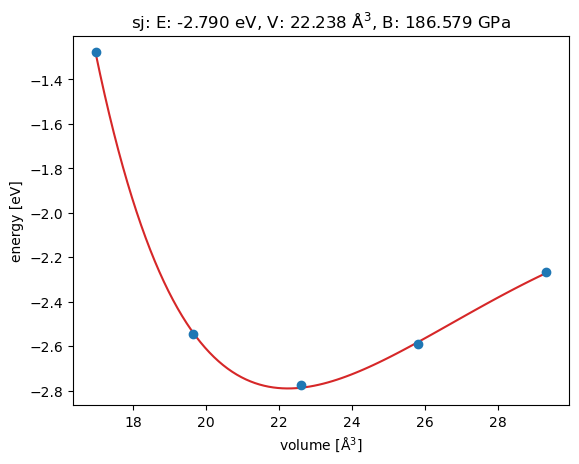

In [38]:
from ase import Atoms
from ase.io.trajectory import Trajectory
from ase.calculators.emt import EMT
from ase.units import kJ
from ase.eos import EquationOfState

a = 4.079  # Lattice constant for BCC Fe is 2.866Å
b = a / 2
Fe = Atoms('Ag',
           cell=[(0, b, b), (b, 0, b), (b, b, 0)], 
           pbc=1,
           calculator=LennardJones(sigma=2.887 , epsilon=0.35))#0.70641))=epsilon  sigma=2.26738# Sigma is prob in Å what unit is epsilon? eV/atom?
cell = Fe.get_cell()
traj = Trajectory('Fe.traj', 'w')
for x in np.linspace(1, 1.2, 5):
    Fe.set_cell(cell * x, scale_atoms=True)
    cur_nrg = Fe.get_potential_energy()
    traj.write(Fe)

configs = read('Fe.traj@:')

volumes = [Fe.get_volume() for Fe in configs]
energies = [Fe.get_potential_energy() for Fe in configs]
eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
print(B / kJ *1.0e24, 'GPa')
eos.plot('FeEos.png')  # No minimum since volumes and energies becomes only one


100.04302802795478 GPa


<AxesSubplot: title={'center': 'sj: E: -0.000 eV, V: 16.775 Å$^3$, B: 100.043 GPa'}, xlabel='volume [Å$^3$]', ylabel='energy [eV]'>

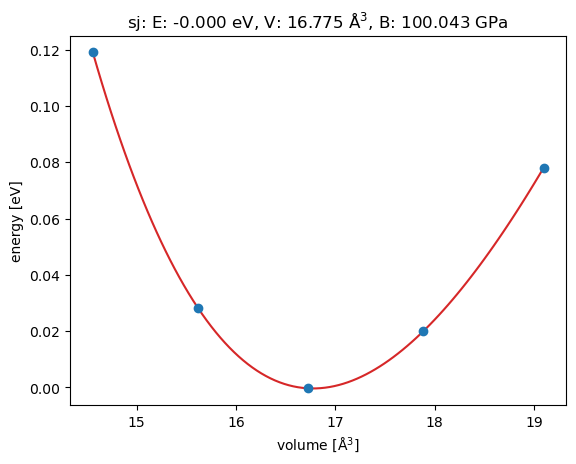

In [39]:
a = 4.08
b = a / 2
ag = Atoms('Ag',
           cell=[(0, b, b), (b, 0, b), (b, b, 0)],
           pbc=1,
           calculator=EMT())  # use EMT potential
cell = ag.get_cell()
traj = Trajectory('Ag.traj', 'w')
for x in np.linspace(0.95, 1.04, 5):
    ag.set_cell(cell * x, scale_atoms=True)
    ag.get_potential_energy()
    traj.write(ag)

configs = read('Ag.traj@:')  # read 5 configurations
# Extract volumes and energies:
volumes = [ag.get_volume() for ag in configs]
energies = [ag.get_potential_energy() for ag in configs]
eos = EquationOfState(volumes, energies)
v0, e0, B = eos.fit()
print(B / kJ * 1.0e24, 'GPa')
eos.plot('Ag-eos.png')


### Phonon spectra

In [170]:
### Do solely with phonopy even though some parts may be done with ASE

### Cleaning up

In [26]:
import glob, os
import itertools as it

def rm(file):
    try:
        os.remove(file)
    except OSError:
        pass

L1 = glob.glob("CALCULATED_DATA/*")
L2 = glob.glob("CCS_*")
L3 = glob.glob("*.traj")
L4 = glob.glob("*.png")

for file in it.chain(L1, L2, L3, L4):
    rm(file)

rm("structures.json")
rm("file_list")
rm("LJ.db")
